# Home assignment 1. Autoencoders & Frechet Inception Distance

In this home assignment I built an autoencoder and trained it on CIFAR10. To measure the performance I also wrote Frechet Inception Distance (FID) function. After traning on CIFAR10 using the same autoencoder I extracted embeddings of [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) dataset and measured FID. 

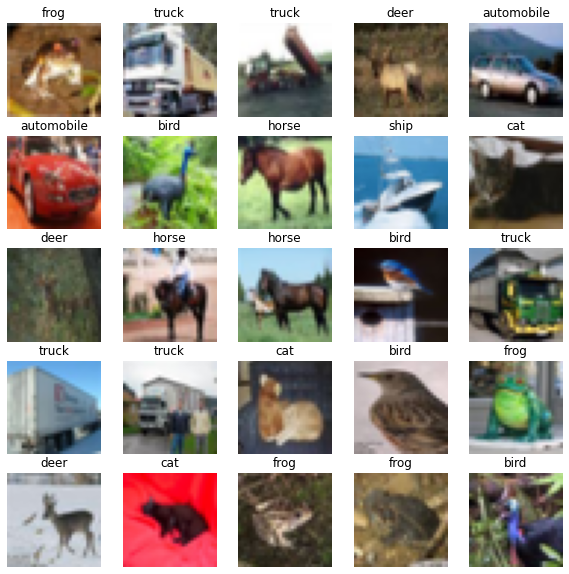

In [5]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

I've extracted embeddings with encoder and then classified them using Gradient Boosting.

In [23]:
score = classification_score(encoder, train_dataset, val_dataset, 'cuda')
assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0758           16.06m
         2           1.9134           12.95m
         3           1.7819           11.51m
         4           1.6711           10.67m
         5           1.5780           10.09m
         6           1.4975            9.63m
         7           1.4238            9.25m
         8           1.3584            9.05m
         9           1.2955            8.73m
        10           1.2405            8.43m
        20           0.8541            6.04m
        30           0.6317            3.98m
        40           0.4922            1.98m
        50           0.3950            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.4218

I reconstructed images from embeddings using decoder. You can compare the orginal and reconstructed images

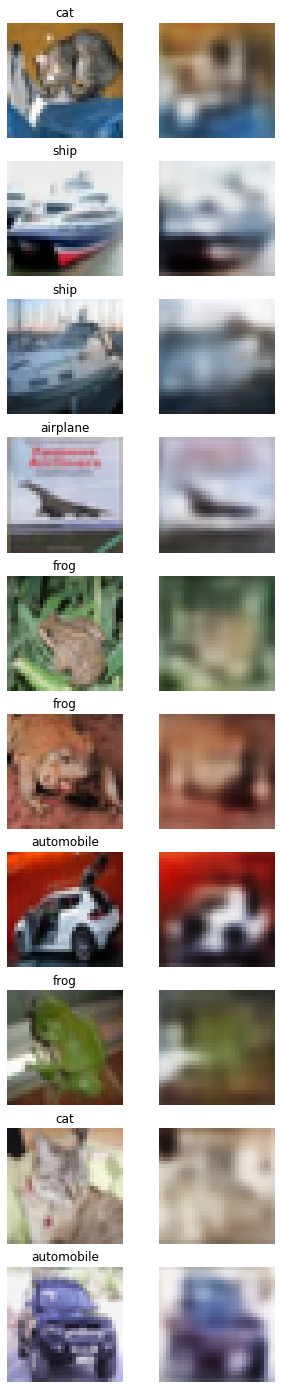

In [24]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

Frechet Inception Distance
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [28]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

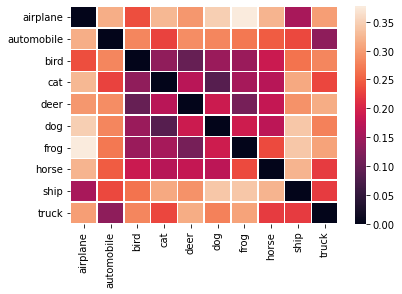

In [29]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

I extracted embeddings of [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats) dataset and measured FID.

In [31]:
from torchvision.datasets import ImageFolder

mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(125),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset = ImageFolder('./PetImages', transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False, num_workers=0)

cats_and_dogs = get_representations(dataloader, encoder, device)
fid = calculate_fid(
            torch.stack(cats_and_dogs[0], dim=0).cpu().numpy(),
            torch.stack(cats_and_dogs[1], dim=0).cpu().numpy()
        )

fid

  0%|          | 0/24998 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

0.12518808760262773

## Give examples of the application of autoencoders in other relevant tasks and don't forget to add some funny memes.

We can also use autoencoders for Image retrieval tasks. The main goal of Image retrieval is to extract compact feature embeddings from images. People build some successful models with supervised techniques but in many cases, we don't always have labeled data and it's expensive to assign labels to unlabeled samples. However, we also can get image embeddings with autoencoders in unsupervised manner. In this home assignment we also extracted separate feature representations of images using autoencoders. <br> People have tried to use autoencoders for image retrieval tasks but attempts were less successful than supervised learning approaches and need research. There are some links to papers:
* [Using Very Deep Autoencoders for Content-Based Image Retrieval. Alex Krizhevsky, Geoffrey E. Hinton 2011](https://www.cs.toronto.edu/~hinton/absps/esann-deep-final.pdf)
* [Deep Convolutional AutoEncoder-based Lossy Image Compression. Zhengxue Cheng, Heming Sun, Masaru Takeuchi, Jiro Katto 2018](https://arxiv.org/abs/1804.09535)
* [Auto-Encoders for Content-based Image Retrieval with its Implementation Using Handwritten Dataset. Rupapara, V., Narra, M., Gonda, N. K., Thipparthy, K., & Gandhi, S. 2020.](https://ieeexplore.ieee.org/abstract/document/9138007)
* [RCAE_BFV: Retrieve Encrypted Images Using Convolution AutoEncoder and BFV. Emad M. Alsaedi, Alaa kadhim Farhan 2022](https://scholar.google.com/citations?view_op=view_citation&hl=ru&user=Xh9lOdsAAAAJ&citation_for_view=Xh9lOdsAAAAJ:UeHWp8X0CEIC)

Memes:<br>
<img src="https://imgur.com/0ZXBsnR.png"/>
<img src="https://imgur.com/m6qiPJH.png"/>